In [ ]:
### IMPORT PACKAGES
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from transformers import BertModel
from transformers import BertTokenizer
import warnings

nltk.download('punkt_tab')
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
imdb_df = pd.read_csv('imdb_with_glove_bert_embeddings.csv')

In [ ]:
X = imdb_df['review']
y = imdb_df['sentiment']

labs = [1 if label == "positive" else 0 for label in y]
labels = torch.tensor(labs).float().unsqueeze(1)

In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="pt")
val_enc = tokenizer(list(X_val), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_enc = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors="pt")

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
        'input_ids': self.encodings['input_ids'][idx],
        'attention_mask': self.encodings['attention_mask'][idx],
        'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
train_dataset = IMDbDataset(train_enc, y_train)
val_dataset = IMDbDataset(val_enc, y_val)
test_dataset = IMDbDataset(test_enc, y_test)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def evaluate():
  model.eval()
  y_preds = []
  y_true = []

  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs.logits, dim=1)
      y_preds.extend(preds.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_preds)
    print(f'Validation Accuracy: {accuracy}')
    print(classification_report(y_true, y_preds))

In [ ]:
def train():
  model.train()
  for e in range(epochs):
    total_loss = 0
    for batch in train_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    print(f"Epoch {e + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")
    evaluate()

In [ ]:
from transformers import AdamW

## Hyperparameter tuning
epoch_list = [2] #[1,2,3,4,5]
learning_rate_list = [2e-5] #[1e-5, 2e-5, 5e-5, 1e-4]

for epoch in epoch_list:
  for learning_rate in learning_rate_list:
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    epochs = epoch
    train()

Epoch 1/2, Loss: 0.28153373573869467
Validation Accuracy: 0.9143
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4937
           1       0.94      0.88      0.91      5063

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

Epoch 2/2, Loss: 0.13782043329626323
Validation Accuracy: 0.9165
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4937
           1       0.93      0.91      0.92      5063

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
model.eval()
y_preds = []
y_true = []
y_probs = []

with torch.no_grad():
  for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)\

    outputs = model(input_ids, attention_mask=attention_mask)
    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(outputs.logits, dim=1)
    y_preds.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    y_probs.extend(probs[:, 1].cpu().numpy())

accuracy = accuracy_score(y_true, y_preds)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(y_true, y_preds))

auc = roc_auc_score(y_true, y_probs)
print(f'Validation AUC: {auc}')

Validation Accuracy: 0.9165
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4937
           1       0.93      0.91      0.92      5063

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Validation AUC: 0.9745365374206808


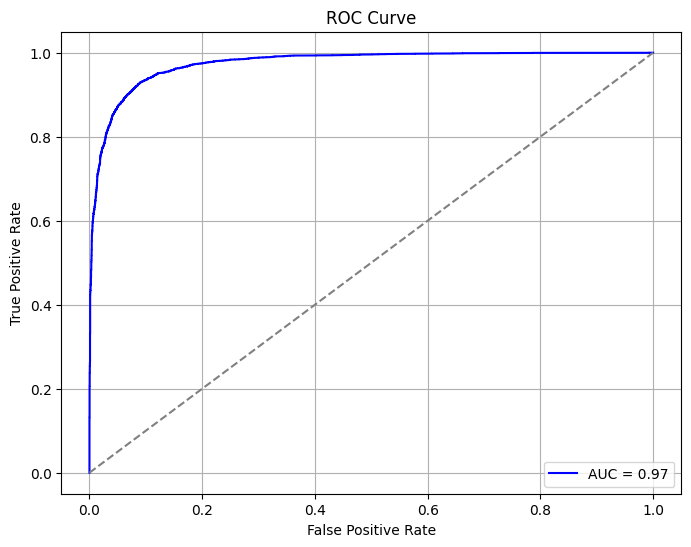

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
model.eval()
y_preds = []
y_true = []
y_probs = []

with torch.no_grad():
  for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)\

    outputs = model(input_ids, attention_mask=attention_mask)
    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(outputs.logits, dim=1)
    y_preds.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    y_probs.extend(probs[:, 1].cpu().numpy())

accuracy = accuracy_score(y_true, y_preds)
print(f'Test Accuracy: {accuracy}')
print(classification_report(y_true, y_preds))

auc = roc_auc_score(y_true, y_probs)
print(f'Test AUC: {auc}')

Test Accuracy: 0.9174
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4961
           1       0.92      0.92      0.92      5039

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Test AUC: 0.9748500898794682


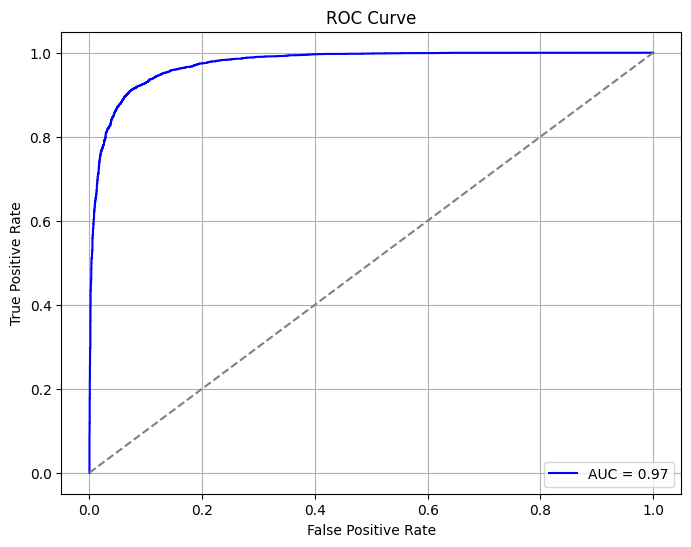

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()